In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

%matplotlib inline

In [3]:
df = pd.read_csv('data/titanic.csv', index_col='PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# df.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

# EDA

In [5]:
df.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

## Numerik vs Target

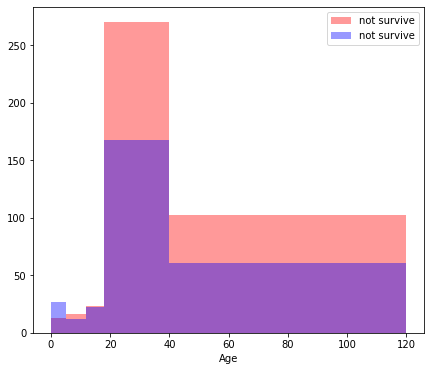

In [12]:
plt.figure(figsize=(7,6))
sns.distplot(df.query('Survived == 0')['Age'], bins=[0, 5, 12, 18, 40, 120], color='r', label='not survive', kde=False)
sns.distplot(df.query('Survived == 1')['Age'], bins=[0, 5, 12, 18, 40, 120], color='b', label='not survive', kde=False)
plt.legend();

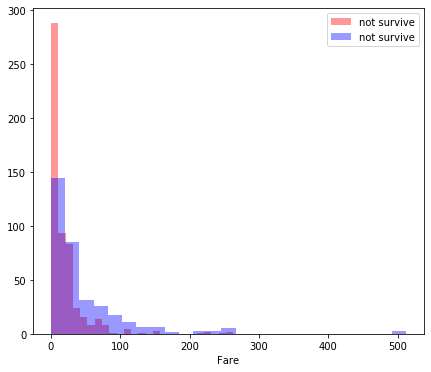

In [14]:
# plot fare vs survive

plt.figure(figsize=(7,6))
sns.distplot(df.query('Survived == 0')['Fare'], bins=25, color='r', label='not survive', kde=False)
sns.distplot(df.query('Survived == 1')['Fare'], bins=25, color='b', label='not survive', kde=False)
plt.legend();

## Kategori vs target

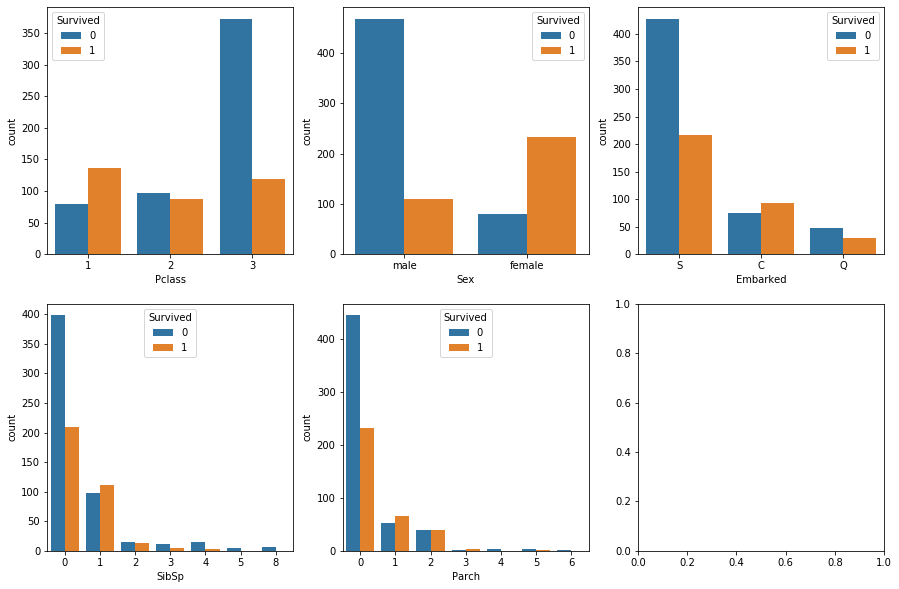

In [17]:
category_variables = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for category, a in zip(category_variables, ax.flatten()):
    sns.countplot(category, data=df, hue='Survived', ax=a);

1. bin kids
2. bin fare
3. indicate sendirian atau ngga

## Feature Engineering

### Add isAlone

In [19]:
df["isAlone"] = (df.SibSp == 0) & (df.Parch == 0)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,False
2,1,1,female,38.0,1,0,71.2833,C,False
3,1,3,female,26.0,0,0,7.9250,S,True
4,1,1,female,35.0,1,0,53.1000,S,False
5,0,3,male,35.0,0,0,8.0500,S,True


### Binning

In [20]:
df.Age = pd.cut(df.Age, [0, 5, 12, 18, 40, 120], labels=['balita', 'anak-anak', 'remaja', 'dewasa', 'lansia'])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,dewasa,1,0,7.2500,S,False
2,1,1,female,dewasa,1,0,71.2833,C,False
3,1,3,female,dewasa,0,0,7.9250,S,True
4,1,1,female,dewasa,1,0,53.1000,S,False
5,0,3,male,dewasa,0,0,8.0500,S,True


In [21]:
df.Age.value_counts(normalize=True)

dewasa       0.595238
lansia       0.210084
remaja       0.098039
balita       0.061625
anak-anak    0.035014
Name: Age, dtype: float64

In [23]:
df.Fare = pd.cut(df.Fare, [0, 25, 100, 600], labels=['murah', 'mahal', 'eksekutif'])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,dewasa,1,0,murah,S,False
2,1,1,female,dewasa,1,0,mahal,C,False
3,1,3,female,dewasa,0,0,murah,S,True
4,1,1,female,dewasa,1,0,mahal,S,False
5,0,3,male,dewasa,0,0,murah,S,True


In [24]:
X = df.drop(columns = 'Survived')
y = df.Survived

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 8), (179, 8), (712,), (179,))

In [27]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # step 1: impute
    ('scaler', MinMaxScaler()) # step 2: scale
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

# merge pipelines
preprocessor = ColumnTransformer([
    ('numeric', numerical_pipeline, ['SibSp', 'Parch']), # pipa 1
    ('categoric', categorical_pipeline, ['Pclass', 'Age', 'Fare', 'Sex', 'Embarked', 'isAlone']) # pipa 2
])

In [28]:
from jcopml.tuning import grid_search_params as gsp

In [29]:
gsp.knn_params

{'algo__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
 'algo__weights': ['uniform', 'distance'],
 'algo__p': [1, 1.5, 2]}

In [30]:
pipeline = Pipeline([
    ('prep', preprocessor), # preprocessing
    ('algo', KNeighborsClassifier()) # fitting algoritma ke data
])

model = GridSearchCV(pipeline, gsp.knn_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s


{'algo__n_neighbors': 25, 'algo__p': 2, 'algo__weights': 'distance'}
0.8792134831460674 0.8146237397912751 0.7988826815642458


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   13.8s finished


### cuma naik 1 persen
### effort ga sebanding hasil :(